In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
from lightgbm import LGBMClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [4]:
train = pd.read_csv('Train.csv').fillna(0)
test = pd.read_csv('Test.csv').fillna(0)

In [5]:
random = 2019

# Basic Exploratory Analysis

In [6]:
def pred(data):
    default_status = []
    for i in train.default_status:
        if i == 'no':
            default_status.append(0)
        else:
            default_status.append(1)
    data['default_status'] = default_status
    return data
train = pred(train)

In [7]:
#Label Encoding
train.form_field47 = le.fit_transform(train.form_field47).astype(np.uint8)
test.form_field47 = le.fit_transform(test.form_field47).astype(np.uint8)

### Feature Engineering

In [8]:
train['collateral_salary'] = train.form_field15 - train.form_field14
train['credit*risk'] = train['form_field1'] * train['form_field2']

test['collateral_salary'] = test.form_field15 - test.form_field14
test['credit*risk'] = test['form_field1'] * test['form_field2']

In [11]:
X = train.drop(['Applicant_ID', 'default_status'], axis =1)
y = train.default_status

#### Upsampling the data

This method was not that helpful due to little or no sign of improvement i notice it late and decided to stick with

In [12]:
print('Number of class 1 samples before:',X[y == 1].shape[0])

Number of class 1 samples before: 13715


In [13]:
X_upsampled, y_upsampled = resample(X[y == 1],y[y == 1],replace=True,n_samples=X[y == 0].shape[0],random_state=123)
print('Number of class 1 samples after:',X_upsampled.shape[0])

Number of class 1 samples after: 42285


In [14]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify = y_bal, test_size=0.2, random_state=42)

## ML Model 

In [16]:
lgm = LGBMClassifier(n_estimators=300, random_state=random)
ext = ExtraTreesClassifier(n_estimators=300, random_state=random)
rfc = RandomForestClassifier(n_estimators=300, random_state=random)

classifier = [lgm, ext , rfc]
classifier_names = ['LR', 'EXT','Random Forest']

In [17]:
def pred (model):
    for i, model in enumerate(classifier):
        model.fit(X_train,y_train)
        pred = model.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test,pred)
        print(f'{classifier_names[i]}:{roc}')

def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
        fpr, tpr, _ = roc_curve(labels, predictions)
    return fpr, tpr

In [18]:
pred(classifier)

LR:0.8993572769249426
EXT:0.9843732140260246
Random Forest:0.9824110099699739


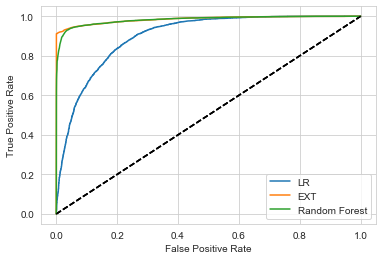

In [19]:
for i, model in enumerate(classifier):
    fpr, tpr = test_roc(model, X_test, y_test)
    plt.plot(fpr, tpr, label=classifier_names[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

### A KFold Voting Classifier of Catboost and Lightgbm Model

In [20]:
vcf = VotingClassifier(estimators=[('lr', lgm), ('rf', ext), ('gnb', rfc)], voting='soft')

In [21]:
cv_score = []
test_score = []
split = 10
fold = KFold(n_splits=split, shuffle=True, random_state=random)

for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    vcf.fit(X_train,y_train)

    y_pred = vcf.predict_proba(X_test)[:,1]

    print('ROC_AUC_SCORE:', roc_auc_score(y_test,y_pred), '*'*30)

    cv_score.append(roc_auc_score(y_test,y_pred))

    p = vcf.predict_proba(test[X.columns])[:,1]

    test_score.append(p)

ROC_AUC_SCORE: 0.8357523466530715 ******************************
ROC_AUC_SCORE: 0.8425893426862118 ******************************
ROC_AUC_SCORE: 0.8366142459049042 ******************************
ROC_AUC_SCORE: 0.8450669676643703 ******************************
ROC_AUC_SCORE: 0.8411702441789652 ******************************
ROC_AUC_SCORE: 0.8311825434068512 ******************************
ROC_AUC_SCORE: 0.8414458504634109 ******************************
ROC_AUC_SCORE: 0.8333258527711871 ******************************
ROC_AUC_SCORE: 0.8389544234859314 ******************************
ROC_AUC_SCORE: 0.8432792591388718 ******************************


In [22]:
print(f'Mean of ROC Score: {np.array(cv_score).mean()}')

Mean of ROC Score: 0.8389381076353775


In [24]:
prediction = np.sum(np.array(test_score),axis=0)/split

### Creating Prediction file

In [25]:
sub = pd.DataFrame({'Applicant_ID':test.Applicant_ID, 'default_status':prediction})

In [26]:
sub.to_csv('vcf_kfold_submission.csv', index = False)

In [27]:
sub.describe()

,default_status
count,24000.000000
mean,0.247818
std,0.220490
min,0.000228
25%,0.060048
50%,0.186535
75%,0.386326
max,0.935268
